# Kaggle - Titanic Survival

This is an exploratory categorization problem to identify whether someone will survive the Titanic crash based on different attributes. 

Several different categorization schemes will be tested.

In [253]:
import itertools
import operator
import pandas_profiling
import warnings
warnings.filterwarnings("ignore")

import category_encoders as ce
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import randint, mode

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.base import clone

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [254]:
train_df = pd.read_csv("train.csv") # import train dataset
test_df  = pd.read_csv("test.csv")  # import test dataset

# Cleaning up Data

In [255]:
train_df.Survived.unique()

array([0, 1])

In [256]:
train_df.Pclass.unique()

array([3, 1, 2])

In [257]:
# encode the sex of the passengers
train_df.Sex = train_df.Sex.map({ 'male' : 0, 'female' : 1 }).astype(int)

In [258]:
def plot_distribution(series):
    '''Plot distribution compared to normal and print out some summary statistics'''
    from scipy import stats
    
    mu, sigma, skew = series.mean(), series.std(), series.skew()
    print( '\n mu = {:.2f}, sigma = {:.2f}, skew = {:.2f}'.format(mu, sigma, skew))
    
    fig = plt.figure()
    fig.set_size_inches(8, 4)

    sns.distplot(series, fit=stats.norm)
    
    plt.tight_layout()


 mu = 29.70, sigma = 14.53, skew = 0.39


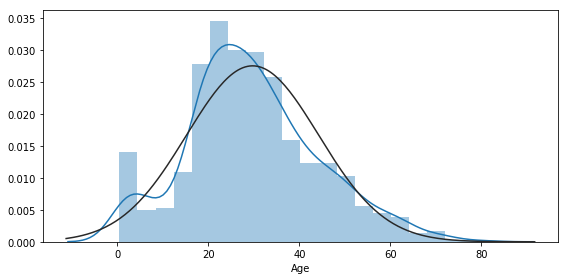

In [259]:
plot_distribution(train_df[train_df.Age.notnull()].Age)

In [260]:
train_df.Age = train_df.Age.fillna(train_df.Age.median())

In [261]:
train_df.SibSp.unique()

array([1, 0, 3, 4, 2, 5, 8])

In [262]:
train_df.Parch.unique()

array([0, 1, 2, 5, 3, 4, 6])

In [263]:
len(train_df.Ticket.unique())

681


 mu = 32.20, sigma = 49.69, skew = 4.79


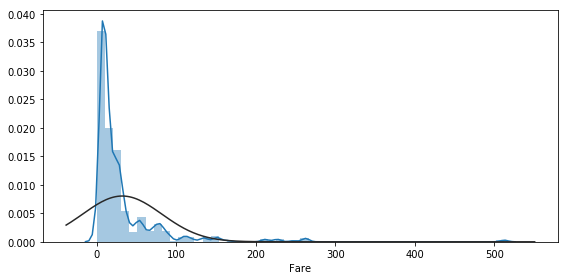

In [264]:
train_df.Fare = train_df.Fare.fillna(train_df.Fare.median())
plot_distribution(train_df.Fare)

In [265]:
train_df.Fare.sort_values()[::-1][:4]

679    512.3292
258    512.3292
737    512.3292
341    263.0000
Name: Fare, dtype: float64

In [266]:
train_df = train_df[train_df.Fare < 300]

In [267]:
# log transform the fare
train_df['logFare'] = np.log1p(train_df.Fare)

In [268]:
# fill in passengers without cabins
train_df.Cabin = train_df.Cabin.fillna(value='None')
train_df['has_cabin'] = [0 if x == 'None' else 1 for x in train_df.Cabin]

In [269]:
# fill in embarked with the mode
train_df.Embarked = train_df.Embarked.fillna(value='S')

In [270]:
# Dummy encode embarked location
def append_dummies(df, columns):
    ''' Append dummy versions of columns to a dataframe '''
    for col in columns:
        dummy_col = pd.get_dummies(df[col], drop_first=True)
        df[dummy_col.columns.tolist()] = dummy_col
    return df
train_df = append_dummies(train_df, ['Embarked'])

# Trends in Data

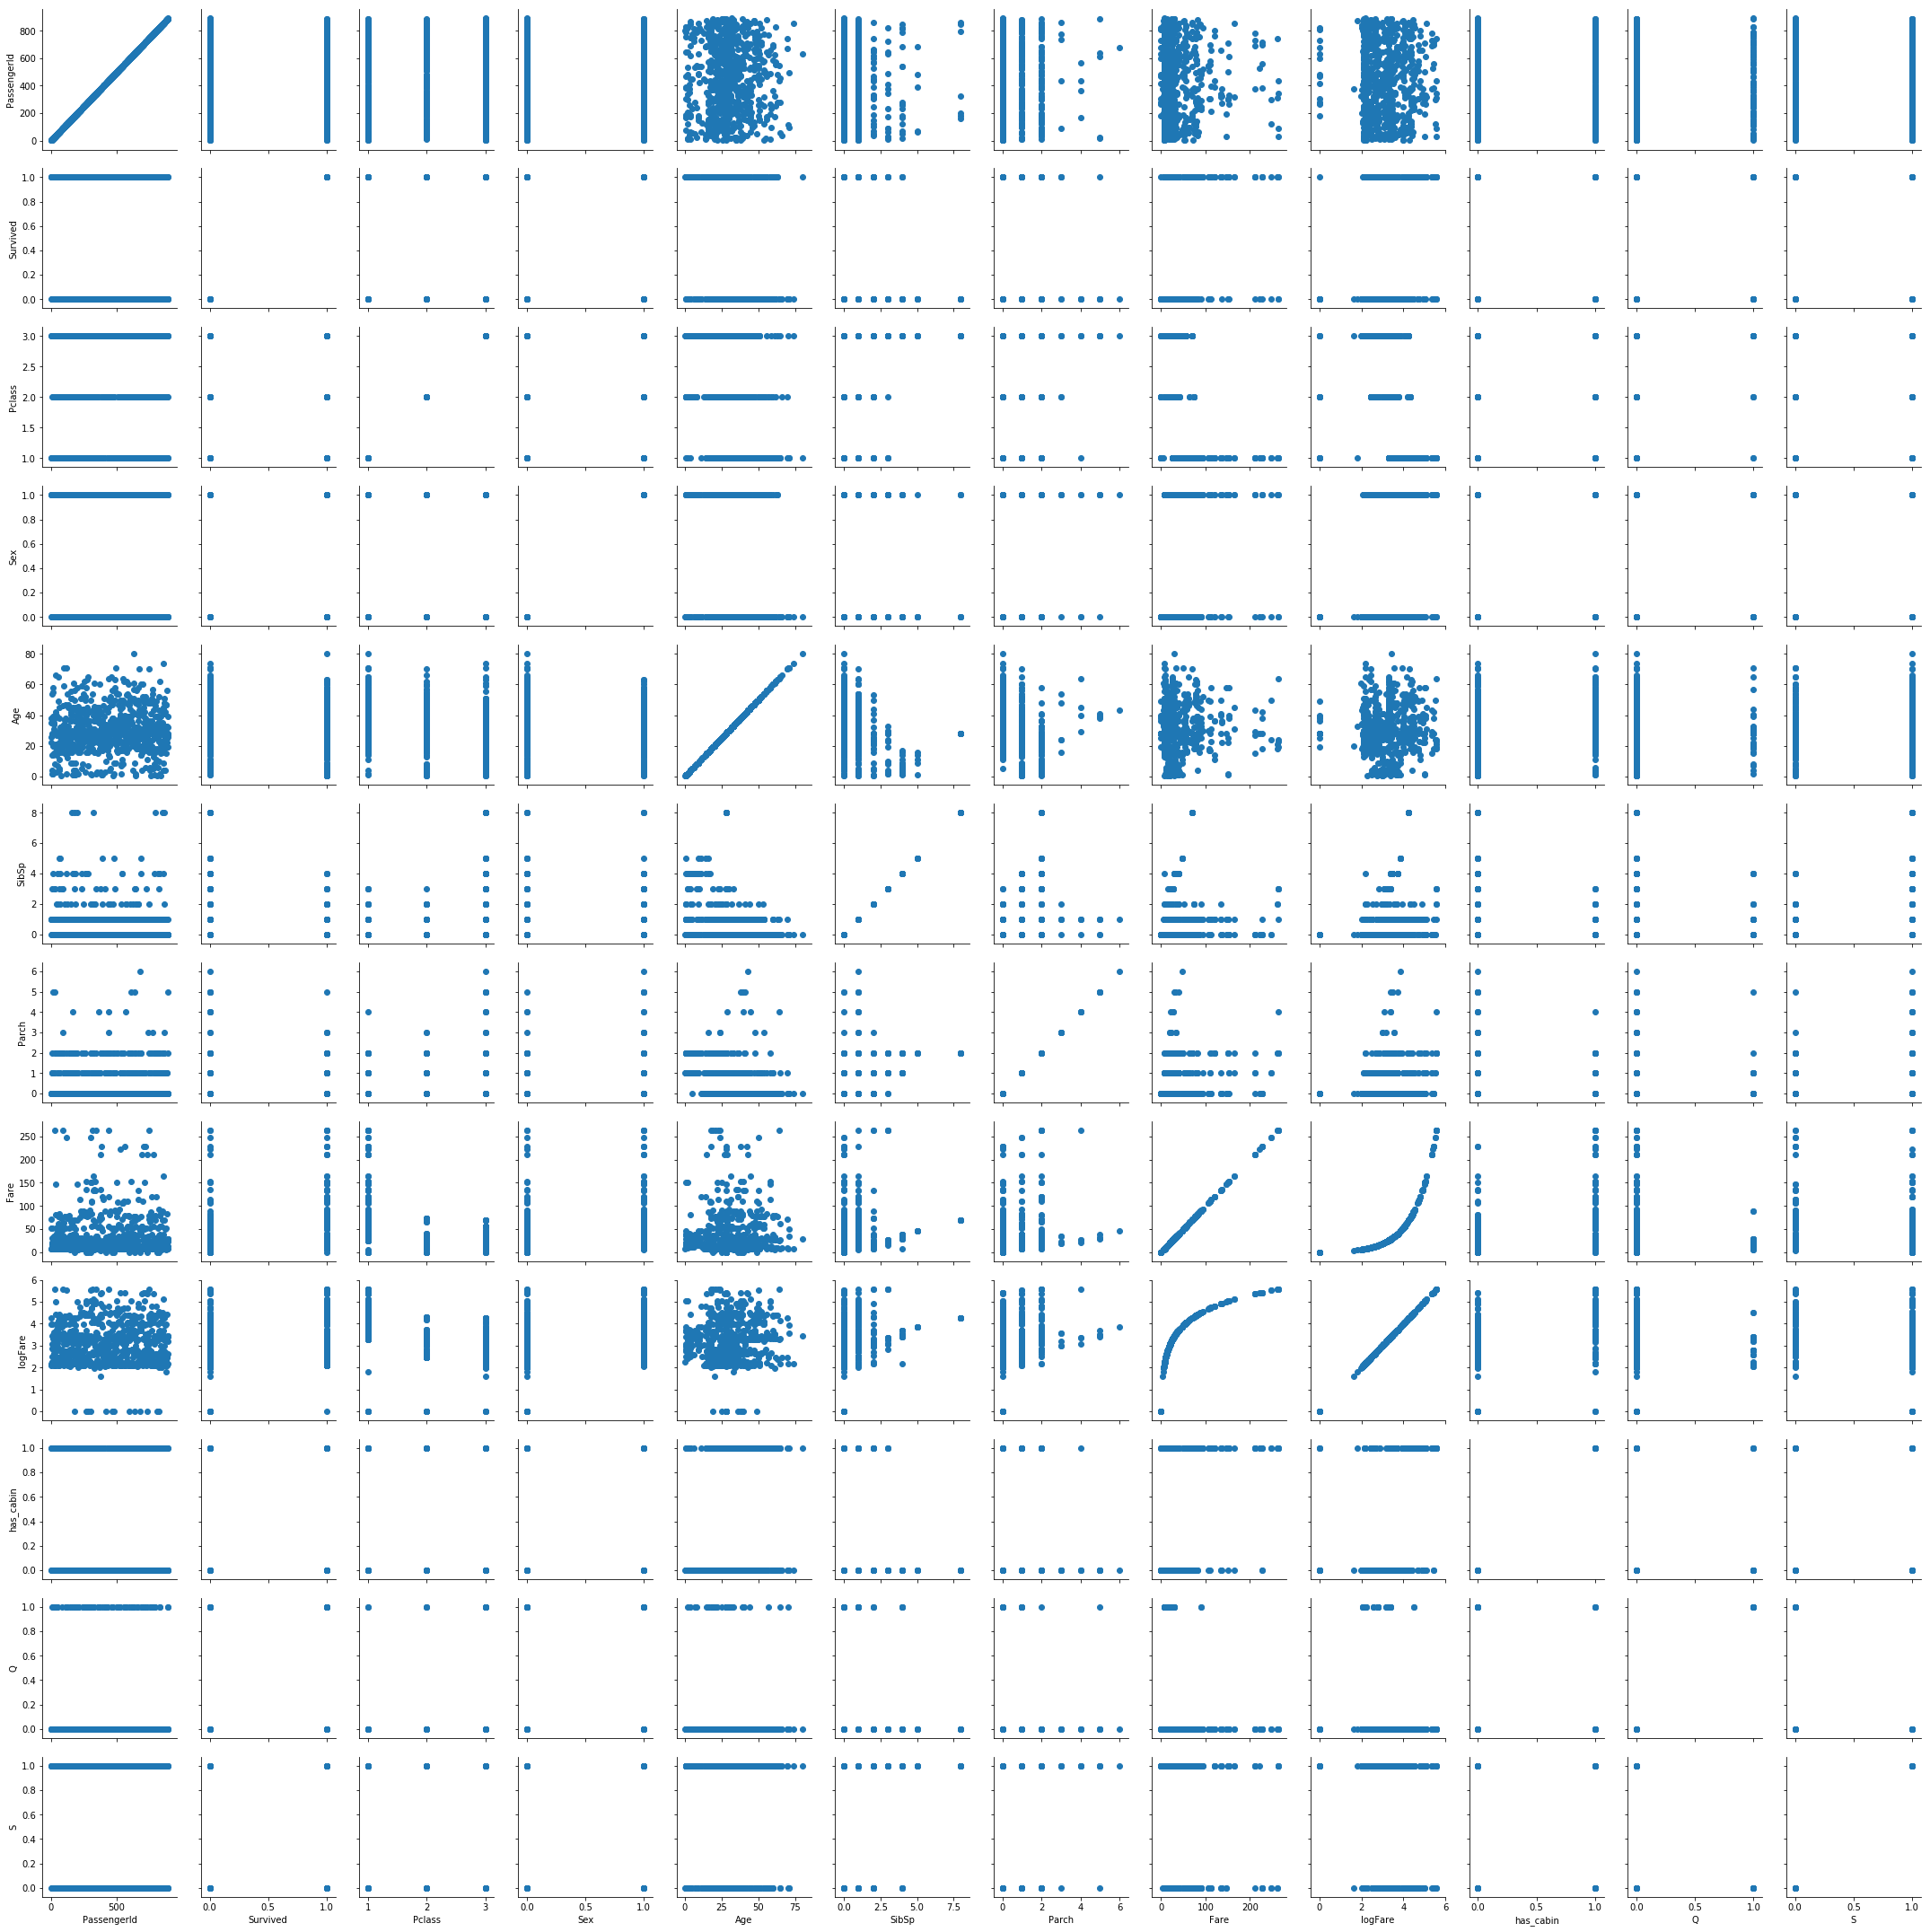

In [271]:
sns.PairGrid(train_df).map(plt.scatter);

In [518]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 
            'logFare', 'has_cabin', 'Q', 'S'] 
target   = 'Survived'

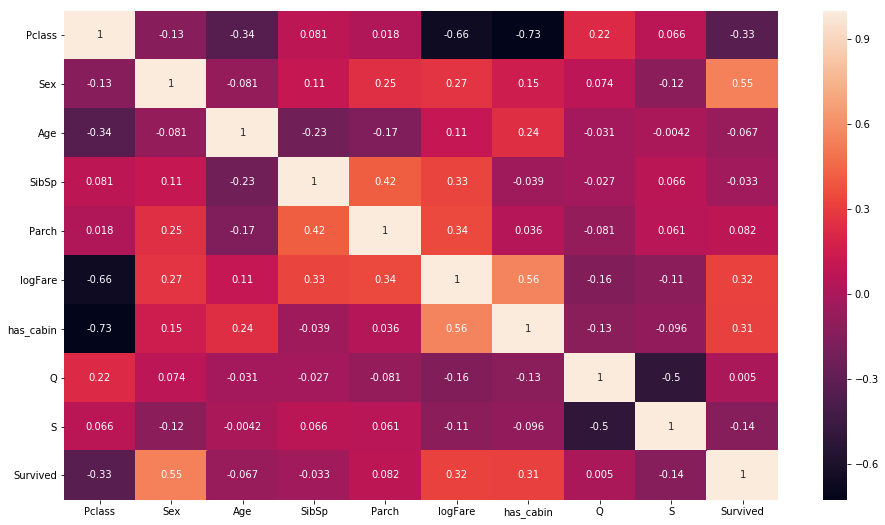

In [273]:
fig = plt.figure()
fig.set_size_inches(16, 9)
sns.heatmap(train_df[features+[target]].corr(), annot=True);

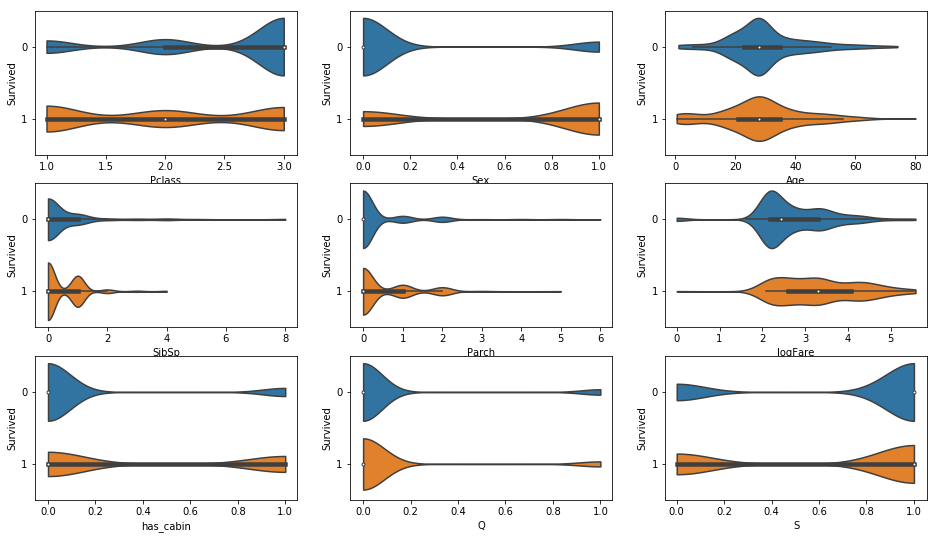

In [274]:
# plot the distributions of variables in the different classes
fig = plt.figure()
fig.set_size_inches(16, 9)
for i, col in enumerate(features):
    ax = fig.add_subplot(3,3,i+1)
    sns.violinplot(x=col, y='Survived', data=train_df, cut=0, orient='h')

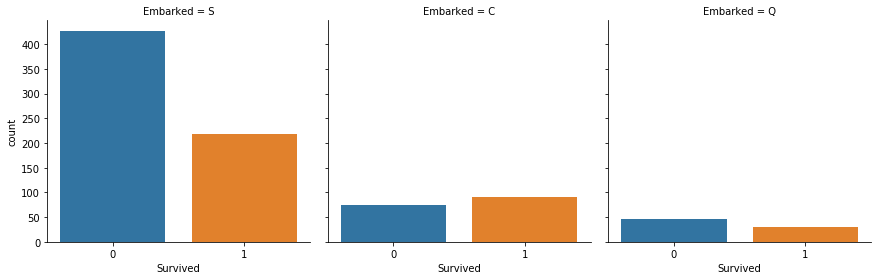

In [275]:
sns.factorplot("Survived", col="Embarked", col_wrap=4, data=train_df, kind="count");

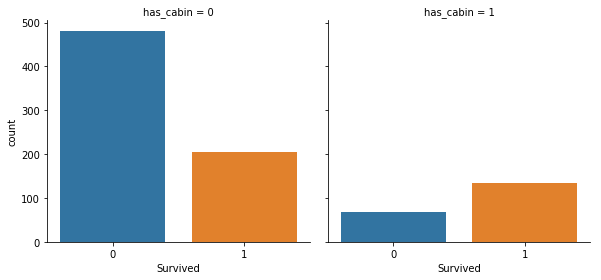

In [276]:
sns.factorplot("Survived", col="has_cabin", col_wrap=4, data=train_df, kind="count");

# Functions for Model Building

In [277]:
def hyperparam_search(base_clf, parameters, scores, X_train, X_test, y_train, y_test, strategy='grid'):
    ''' Do a grid search and return the final classifer if only evaluating on one metric '''

    # loop over the different scores and see what parameters are best for the different metrics
    for score in scores:
#       print("Tuning hyper-parameters for %s\n" % score)

        if strategy == 'grid':
            clf = GridSearchCV(base_clf, parameters, cv=KFold(5), scoring=score)
        else:
            clf = RandomizedSearchCV(base_clf, parameters, cv=KFold(5), scoring=score, n_iter=20)
        clf.fit(X_train, y_train)

        print("Best parameters set found:\n")
        print(clf.best_params_)
        print()
        print("Grid scores:\n")
        means = clf.cv_results_['mean_test_score']
        stds  = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()
        
    # train the final model on the full training set
    if len(scores) == 1:
        clf = clf.best_estimator_.fit(X_train, y_train)
        
    return clf

In [278]:
def plot_roc(trained_models, X_test, y_test):
    ''' Plot ROC Curve '''
    
    fig = plt.figure()
    fig.set_size_inches(10, 8)
    for i, (name, clf) in enumerate(trained_models.items()):
    
        # get the fpr and tpr
        fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
        roc_auc = auc(fpr, tpr)

        # plot everything
        plt.plot(fpr, tpr,lw=2, label='{:4.3f}: {}'.format(roc_auc, name))
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

        # format plot
        plt.xlim([-.02, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=14)
        plt.ylabel('True Positive Rate', fontsize=14)
#       plt.title('ROC', fontsize=20)
        plt.legend(loc="lower right", fontsize=20)

    plt.show()

In [279]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig = plt.figure()
    fig.set_size_inches(4, 4)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
# define a function to summarize a confusion matrix
def confusion_matrix_summary(cm):
    ''' Print out summary statistics of the classifier '''
    tn = cm[0, 0] # true negative
    tp = cm[1, 1] # true positive
    fn = cm[1, 0] # false negative
    fp = cm[0, 1] # false positive

    print('Sensitivity/Recall/True Positive Rate: {}'.format(round(tp / (tp+fn), 3)))
    print('       Specificity/True Negative Rate: {}'.format(round(tn / (tn+fp), 3)))
    print('                            Precision: {}'.format(round(tp / (tp+fp), 3)))
    print('            Negative Predictive Value: {}'.format(round(tn / (tn+fn), 3)))
    print('                  False Negative Rate: {}'.format(round(fn / (fn+tp), 3)))
    print('          Fallout/False Positive Rate: {}'.format(round(fp / (fp+tn), 3)))
    print('                 False Discovery Rate: {}'.format(round(fp / (fp+tp), 3)))
    print('                  False Omission Rate: {}'.format(round(fn / (fn+tn), 3)))
    print('                             Accuracy: {}'.format(round((tp+tn) / (tp+tn+fp+fn), 3)))
    print('                             F1 Score: {}\n'.format(round(2*tp / (2*tp + fp+fn), 3)))

In [280]:
def plot_feature_importance(trained_models):
    
    fig = plt.figure()
    fig.set_size_inches(16, 9)
    for i, (name, pipe) in enumerate(trained_models.items()):

        clf = pipe.named_steps.clf
        # save the feature importance and sort
        feature_importance = {'%s' % features[i]: coef for i, coef in enumerate(clf.coef_[0])}
        ordered_features = sorted(feature_importance, key=lambda dict_key: abs(feature_importance[dict_key]))
        coefficients = [feature_importance[f] for f in ordered_features]
        
        # plot everything
        ax = fig.add_subplot(3,3,i+1) 
        sns.barplot(x=ordered_features, y=coefficients, ax=ax)
        plt.title("Log Odds")
        for item in ax.get_xticklabels():
            item.set_rotation(45)

    plt.show()

# Feature Selection with Logistic Regression

In [1023]:
from sklearn import linear_model
import numpy as np
import scipy.stats as stat

class LogisticRegression(linear_model.LogisticRegression):
    '''
    Wrapper Class for Logistic Regression which has the usual sklearn instance 
    in an attribute self.model, and pvalues, z scores and estimated 
    errors for each coefficient
    '''
           
    def fit(self, X, y):
        ''' 
        Fit the model and also calculate some important statistics 
        Code taken from: https://stats.stackexchange.com/questions/89484/
                            how-to-compute-the-standard-errors-of-a-logistic-regressions-coefficients
        '''
        
        # fit the model
        super().fit(X, y)
               
        # design matrix -- add column of 1's if there's an intercept
        if self.get_params()['fit_intercept']:
            X_design      = np.hstack((np.ones((X.shape[0], 1)), X))  
            self.params   = np.hstack((self.intercept_, self.coef_[0]))
        else:
            X_design    = X
            self.params = self.coef_[0]
        
        # initiate matrix of 0's, fill diagonal with each predicted observation's variance
        predProbs = np.matrix(self.predict_proba(X))
        V = np.matrix(np.zeros(shape = (X_design.shape[0], X_design.shape[0])))
        np.fill_diagonal(V, np.multiply(predProbs[:,0], predProbs[:,1]).A1)

        # covariance matrix
        self.covLogit = np.linalg.inv(np.dot(np.dot(X_design.T,V),X_design))
        
        # standard errors
        self.stderr = np.sqrt(np.diag(self.covLogit))
        
        # z-scores
        self.z_scores = self.params/self.stderr 
        
        # p-values
        self.p_values = [stat.norm.sf(abs(x))*2 for x in self.z_scores] 
        
        # confidence interval
        alpha = 0.05
        q = stats.norm.ppf(1 - alpha / 2)
        lower = self.params - q * self.stderr
        upper = self.params + q * self.stderr
        self.conf_int = np.dstack((lower, upper))[0]
        
    def summary(self, features, alpha=0.05):
        '''
        Print out summary statistics for the trained model
        '''
        
        # check if there's an intercept and save the features
        if self.get_params()['fit_intercept']:
            features = ['Intercept'] + features
        self.features = features

        # print everything
        print("{:>11s}|{:>9s}|{:>9s}|{:>9s}|{:>9s}|{:>9s}|{:>9s}|{:>9s}".format("Name", "Coef.", \
                "Std.Err.", "z-score", "p-value", "[0.025", "0.975]", "Signif."))
        print(85*'-')
        for i in range(len(self.p_values)):
            print("{:10.10s} | {:7.4f} | {:7.4f} | {:7.4f} | {:7.4f} | {:7.4f} | {:7.4f} | {:>6s}".format(\
                    self.features[i], self.params[i], self.stderr[i], self.z_scores[i], self.p_values[i], \
                    self.conf_int[i][0], self.conf_int[i][1], str((self.p_values[i] < alpha))))

In [1029]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'logFare', 'has_cabin', 'Q', 'S'] 
logreg = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df[target], test_size=0.3, random_state=1)
logreg.fit(X_train, y_train);
logreg.summary(features)

       Name|    Coef.| Std.Err.|  z-score|  p-value|   [0.025|   0.975]|  Signif.
-------------------------------------------------------------------------------------
Intercept  |  0.5403 |  1.0794 |  0.5006 |  0.6167 | -1.5752 |  2.6559 |  False
Pclass     | -0.5471 |  0.2358 | -2.3200 |  0.0203 | -1.0093 | -0.0849 |   True
Sex        |  2.4837 |  0.2377 | 10.4484 |  0.0000 |  2.0178 |  2.9496 |   True
Age        | -0.0508 |  0.0095 | -5.3660 |  0.0000 | -0.0693 | -0.0322 |   True
SibSp      | -0.3442 |  0.1367 | -2.5169 |  0.0118 | -0.6122 | -0.0762 |   True
Parch      | -0.1305 |  0.1406 | -0.9281 |  0.3534 | -0.4061 |  0.1451 |  False
logFare    |  0.3613 |  0.1991 |  1.8143 |  0.0696 | -0.0290 |  0.7515 |  False
has_cabin  |  0.6732 |  0.3689 |  1.8250 |  0.0680 | -0.0498 |  1.3963 |  False
Q          | -0.1344 |  0.4540 | -0.2960 |  0.7672 | -1.0243 |  0.7555 |  False
S          | -0.3935 |  0.2949 | -1.3341 |  0.1822 | -0.9716 |  0.1846 |  False


In [1030]:
logreg = LogisticRegression(fit_intercept=False)
logreg.fit(X_train, y_train);
logreg.summary(features)

       Name|    Coef.| Std.Err.|  z-score|  p-value|   [0.025|   0.975]|  Signif.
-------------------------------------------------------------------------------------
Pclass     | -0.4500 |  0.1268 | -3.5481 |  0.0004 | -0.6986 | -0.2014 |   True
Sex        |  2.4800 |  0.2370 | 10.4660 |  0.0000 |  2.0156 |  2.9445 |   True
Age        | -0.0491 |  0.0089 | -5.5194 |  0.0000 | -0.0665 | -0.0316 |   True
SibSp      | -0.3611 |  0.1324 | -2.7263 |  0.0064 | -0.6207 | -0.1015 |   True
Parch      | -0.1477 |  0.1355 | -1.0895 |  0.2759 | -0.4133 |  0.1180 |  False
logFare    |  0.4415 |  0.1253 |  3.5241 |  0.0004 |  0.1959 |  0.6870 |   True
has_cabin  |  0.7099 |  0.3574 |  1.9860 |  0.0470 |  0.0093 |  1.4104 |   True
Q          | -0.1105 |  0.4502 | -0.2453 |  0.8062 | -0.9929 |  0.7720 |  False
S          | -0.3509 |  0.2821 | -1.2437 |  0.2136 | -0.9038 |  0.2021 |  False


In [1031]:
features = ['Pclass', 'Sex', 'Age', 'SibSp',  'logFare', 'has_cabin'] 
X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df[target], test_size=0.3, random_state=1)
logreg.fit(X_train, y_train);
logreg.summary(features)

       Name|    Coef.| Std.Err.|  z-score|  p-value|   [0.025|   0.975]|  Signif.
-------------------------------------------------------------------------------------
Pclass     | -0.5093 |  0.1056 | -4.8228 |  0.0000 | -0.7162 | -0.3023 |   True
Sex        |  2.4750 |  0.2264 | 10.9308 |  0.0000 |  2.0312 |  2.9188 |   True
Age        | -0.0488 |  0.0087 | -5.5997 |  0.0000 | -0.0659 | -0.0317 |   True
SibSp      | -0.4012 |  0.1309 | -3.0646 |  0.0022 | -0.6578 | -0.1446 |   True
logFare    |  0.3802 |  0.1173 |  3.2409 |  0.0012 |  0.1503 |  0.6101 |   True
has_cabin  |  0.7286 |  0.3538 |  2.0594 |  0.0395 |  0.0352 |  1.4220 |   True


In [1032]:
# import statsmodels.api as sm
# logit = sm.Logit(y_train, X_train)

# # fit the model
# result = logit.fit();

In [1033]:
# result.summary2()

# Train Base Models

In [579]:
# classifiers to tune
classifiers = {'LogReg'         : Pipeline([('robust', RobustScaler()), ('clf', LogisticRegression(fit_intercept=False))]),
               'Poly2LogReg'    : Pipeline([('poly', PolynomialFeatures(2)),  ('clf', LogisticRegression())]),
               'SVC-RBF'        : Pipeline([('robust', RobustScaler()), ('clf', SVC(probability=True))]),
               'GaussianNB'     : Pipeline([('clf', GaussianNB())]),
               'BernoulliNB'    : Pipeline([('clf', BernoulliNB())]),
               'DecisionTree'   : Pipeline([('clf', DecisionTreeClassifier())]),
               'XGBClassifier'  : Pipeline([('clf', XGBClassifier())]),
               'LGBMClassifier' : Pipeline([('clf', LGBMClassifier())])
              }
               
# tunable hyperparameters
C_s = np.logspace(-3, 2, 6) # range for regularization parameters
parameters  = {'LogReg'        : {'clf__penalty' : ['l1','l2'], 
                                  'clf__C'       : C_s},
               'Poly2LogReg'   : {'clf__penalty' : ['l1','l2'], 
                                  'clf__C'       : C_s},
               'SVC-RBF'       : {'clf__C'       : C_s,
                                  'clf__gamma'   : C_s},
               'GaussianNB'    : {},
               'BernoulliNB'   : {'clf__alpha'   : C_s},
               'DecisionTree'  : {'clf__max_depth'        : [3, 4, 6, 8, 10]},
               'XGBClassifier' : {'clf__max_depth'        : [3, 4, 6, 8, 10],
                                  'clf__n_estimators'     : [100, 250, 500],
                                  'clf__learning_rate'    : [0.02, 0.04, 0.06, 0.08, 0.1], 
#                                 'clf__subsample'        : [0.5, 0.75, 1.0],
#                                 'clf__colsample_bytree' : [0.4, 0.6, 0.8, 1.0],
                                  'clf__reg_alpha'        : C_s, 
                                  'clf__reg_lambda'       : C_s},
               'LGBMClassifier': {'clf__max_depth'        : [3, 4, 6, 8, 10],
                                  'clf__n_estimators'     : [100, 250, 500],
                                  'clf__learning_rate'    : [0.02, 0.04, 0.06, 0.08, 0.1], 
                                  'clf__reg_alpha'        : C_s, 
                                  'clf__reg_lambda'       : C_s}
              }

# hyperparameter tuning strategies
cv_strategy = {'LogReg'         : 'grid',
               'Poly2LogReg'    : 'grid',
               'SVC-RBF'        : 'grid',
               'GaussianNB'     : 'grid',
               'BernoulliNB'    : 'grid',
               'DecisionTree'   : 'grid',
               'XGBClassifier'  : 'random',
               'LGBMClassifier' : 'random'
              }

# define the metrics we'll use to score the different parameters on
scores = ['accuracy']

# target names
target_names = ['Died', 'Lived']

In [580]:
# get the training and test sets
X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df.Survived, 
                                                    test_size=0.3, random_state=1)

# train all the base classifiers
trained_models = {}
for name, clf in classifiers.items():
    print("Training {}\n".format(name))
    trained_models[name] = hyperparam_search(clf, parameters[name], scores, X_train, 
                                             X_test, y_train, y_test, cv_strategy[name])

Training LogReg

Best parameters set found:

{'clf__C': 1.0, 'clf__penalty': 'l2'}

Grid scores:

0.625 (+/-0.098) for {'clf__C': 0.001, 'clf__penalty': 'l1'}
0.688 (+/-0.065) for {'clf__C': 0.001, 'clf__penalty': 'l2'}
0.625 (+/-0.098) for {'clf__C': 0.01, 'clf__penalty': 'l1'}
0.726 (+/-0.060) for {'clf__C': 0.01, 'clf__penalty': 'l2'}
0.773 (+/-0.044) for {'clf__C': 0.1, 'clf__penalty': 'l1'}
0.789 (+/-0.047) for {'clf__C': 0.1, 'clf__penalty': 'l2'}
0.792 (+/-0.051) for {'clf__C': 1.0, 'clf__penalty': 'l1'}
0.794 (+/-0.046) for {'clf__C': 1.0, 'clf__penalty': 'l2'}
0.791 (+/-0.042) for {'clf__C': 10.0, 'clf__penalty': 'l1'}
0.791 (+/-0.042) for {'clf__C': 10.0, 'clf__penalty': 'l2'}
0.791 (+/-0.042) for {'clf__C': 100.0, 'clf__penalty': 'l1'}
0.791 (+/-0.042) for {'clf__C': 100.0, 'clf__penalty': 'l2'}

Training Poly2LogReg



LinAlgError: Singular matrix

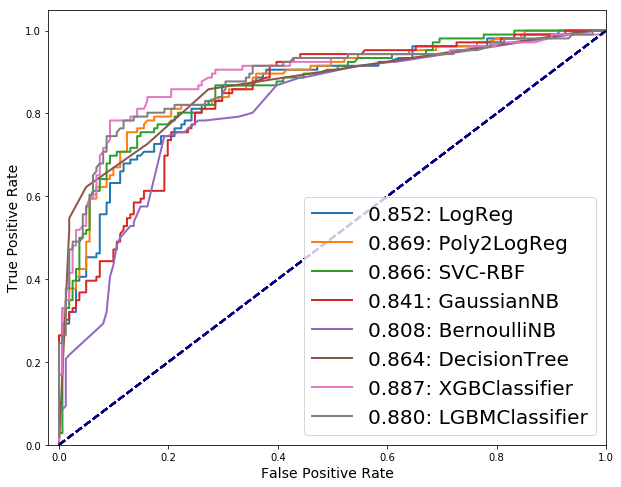

In [288]:
# compute ROC curves 
plot_roc(trained_models, X_test, y_test)

In [289]:
features = ['Pclass', 'Sex', 'Age', 'SibSp',  'logFare'] 
target   = 'Survived'

# get the training and test sets
X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df.Survived, 
                                                    test_size=0.3, random_state=1)

# train all the base classifiers
trained_models = {}
for name, clf in classifiers.items():
    print("Training {}\n".format(name))
    trained_models[name] = hyperparam_search(clf, parameters[name], scores, X_train, 
                                             X_test, y_train, y_test, cv_strategy[name])

Training LogReg

Best parameters set found:

{'clf__C': 0.1, 'clf__penalty': 'l2'}

Grid scores:

0.625 (+/-0.098) for {'clf__C': 0.001, 'clf__penalty': 'l1'}
0.765 (+/-0.080) for {'clf__C': 0.001, 'clf__penalty': 'l2'}
0.625 (+/-0.098) for {'clf__C': 0.01, 'clf__penalty': 'l1'}
0.787 (+/-0.069) for {'clf__C': 0.01, 'clf__penalty': 'l2'}
0.791 (+/-0.042) for {'clf__C': 0.1, 'clf__penalty': 'l1'}
0.808 (+/-0.029) for {'clf__C': 0.1, 'clf__penalty': 'l2'}
0.802 (+/-0.048) for {'clf__C': 1.0, 'clf__penalty': 'l1'}
0.804 (+/-0.033) for {'clf__C': 1.0, 'clf__penalty': 'l2'}
0.807 (+/-0.029) for {'clf__C': 10.0, 'clf__penalty': 'l1'}
0.807 (+/-0.029) for {'clf__C': 10.0, 'clf__penalty': 'l2'}
0.807 (+/-0.029) for {'clf__C': 100.0, 'clf__penalty': 'l1'}
0.807 (+/-0.029) for {'clf__C': 100.0, 'clf__penalty': 'l2'}

Training Poly2LogReg

Best parameters set found:

{'clf__C': 100.0, 'clf__penalty': 'l2'}

Grid scores:

0.770 (+/-0.150) for {'clf__C': 0.001, 'clf__penalty': 'l1'}
0.812 (+/-0.049

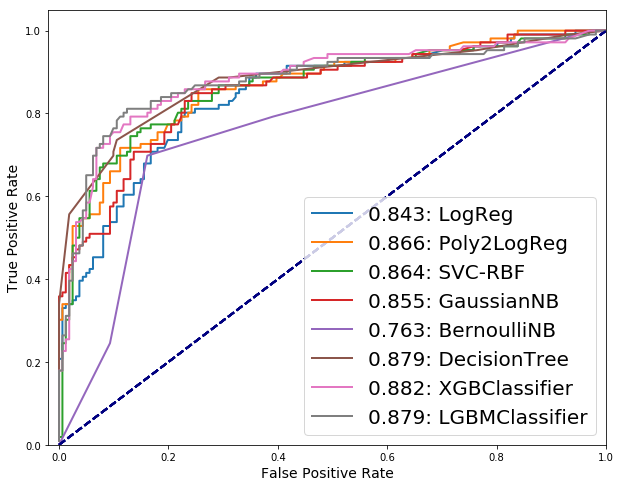

In [290]:
# compute ROC curves 
plot_roc(trained_models, X_test, y_test)

# Nested CV

In [291]:
def nested_cv(base_model, parameters, features, target, strategy='grid'):

    params, scores = [], []
    
    # loop over outer Kfolds
    outer_cv = KFold(10, shuffle=True)
    for train_cv_ind, test_ind in outer_cv.split(train_df[features], train_df[target]):

        # pull out the training/cv and the test sets
        train_cv = train_df.iloc[train_cv_ind]
        test     = train_df.iloc[test_ind]

        # do parameter search
        if strategy == 'grid':
            model = GridSearchCV(base_model, parameters, cv=KFold(5, shuffle=True))
        else:
            model = RandomizedSearchCV(base_model, parameters, cv=KFold(5, shuffle=True), n_iter=20)
        model.fit(X_train, y_train)

        # score the model
        scores.append(accuracy_score(test[target], model.predict(test[features])))
        
        # save the parameters
        params.append(model.best_params_)
    
    # get the mode of the list of best parameters
    param_list  = [str(p) for p in params]
    best_params = eval(mode(param_list)[0].tolist()[0])

    print("Best parameter set found:\n")
    print(best_params)
    print()
    print("Grid scores:\n")
    for score, param in zip(scores, params):
        print('{:.3f} for {}'.format(score, param))
    
    return best_params

In [292]:
# train all the base classifiers
best_params = {}
for name, clf in classifiers.items():
    print("\nTraining {}\n".format(name))
    best_params[name] = nested_cv(clf, parameters[name], features, target, cv_strategy[name])
    clf.set_params(**best_params[name])


Training LogReg

Best parameter set found:

{'clf__C': 0.1, 'clf__penalty': 'l2'}

Grid scores:

0.820 for {'clf__C': 1.0, 'clf__penalty': 'l2'}
0.798 for {'clf__C': 0.1, 'clf__penalty': 'l2'}
0.798 for {'clf__C': 1.0, 'clf__penalty': 'l1'}
0.775 for {'clf__C': 1.0, 'clf__penalty': 'l2'}
0.798 for {'clf__C': 10.0, 'clf__penalty': 'l1'}
0.764 for {'clf__C': 0.1, 'clf__penalty': 'l2'}
0.820 for {'clf__C': 1.0, 'clf__penalty': 'l1'}
0.674 for {'clf__C': 0.1, 'clf__penalty': 'l2'}
0.864 for {'clf__C': 1.0, 'clf__penalty': 'l2'}
0.795 for {'clf__C': 1.0, 'clf__penalty': 'l1'}

Training Poly2LogReg



KeyboardInterrupt: 

# Simple Ensemble Model

In [293]:
class AveragingModels():
    def __init__(self, models):
        self.models = models
        
    # fit to the data
    def fit(self, X, y):      
        # Train base models
        for model in self.models:
            model.fit(X, y)
        return self
    
    # return the mode of the predictions for each model
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models
        ])
        return mode(predictions, axis=1)[0]
    
    
    # return the average probabilities from each model
    def predict_proba(self, X):
        predictions = np.column_stack([
            model.predict_proba(X)[:,1] for model in self.models
        ])
        return np.mean(predictions, axis=1)

In [294]:
averaged_models = AveragingModels( models = classifiers.values() )

In [295]:
# split the training and test set
X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df.Survived, 
                                                    test_size=0.3, random_state=1)

averaged_models.fit(X_train,y_train);

In [296]:
y_pred = averaged_models.predict(X_test)

In [297]:
proba  = averaged_models.predict_proba(X_test)

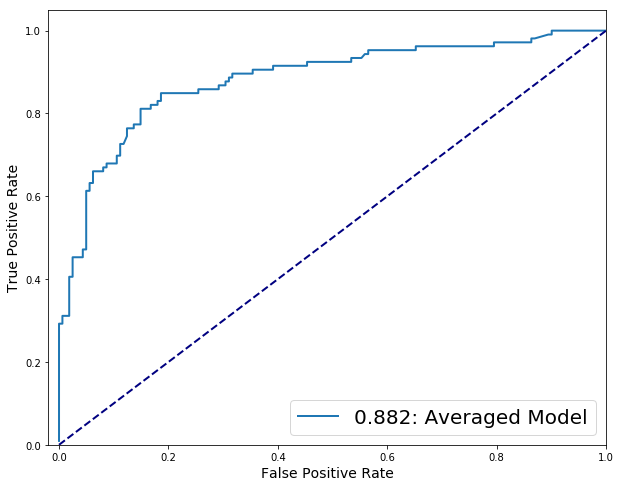

In [298]:
fig = plt.figure()
fig.set_size_inches(10, 8)

# get the fpr and tpr
fpr, tpr, _ = roc_curve(y_test, averaged_models.predict_proba(X_test))
roc_auc = auc(fpr, tpr)

# plot everything
plt.plot(fpr, tpr,lw=2, label='{:4.3f}: {}'.format(roc_auc, 'Averaged Model'))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# format plot
plt.xlim([-.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc="lower right", fontsize=20)
plt.show();

# Make Real Predictions

In [299]:
def clean_data(df):
    ''' Function to clean up a dataframe '''
    
    # encode the sex of the passengers
    df.Sex = df.Sex.map({ 'male' : 0, 'female' : 1 }).astype(int)
    
    # fill in the blanks
    df.Age  = df.Age.fillna(df.Age.median())
    df.Fare = df.Fare.fillna(df.Fare.median())

    # get the log of the fare
    df['logFare'] = np.log1p(df.Fare)
    
    # fill in passengers without cabins
    df.Cabin = df.Cabin.fillna(value='None')
    df['has_cabin'] = [0 if x == 'None' else 1 for x in df.Cabin]
    
    # fill in the embarked location and dummy encode
    df.Embarked = df.Embarked.fillna(value='S')
    df = append_dummies(df, ['Embarked'])
    
    return df

In [305]:
clean_train_df = clean_data(pd.read_csv("train.csv"))
clean_test_df  = clean_data(pd.read_csv("test.csv"))

In [306]:
averaged_models.fit(clean_train_df[features],clean_train_df[target]);

In [307]:
y_pred = averaged_models.predict(clean_test_df[features])

In [308]:
clean_test_df['Survived'] = y_pred

In [309]:
clean_test_df[['PassengerId','Survived']].to_csv('test_predictions.csv',index=False)